In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/figshare-dataset.zip

Archive:  drive/MyDrive/figshare-dataset.zip
   creating: figshare-dataset/
  inflating: figshare-dataset/.DS_Store  
  inflating: __MACOSX/figshare-dataset/._.DS_Store  
   creating: figshare-dataset/meningioma_tumor/
   creating: figshare-dataset/glioma_tumor/
   creating: figshare-dataset/pituitary_tumor/
  inflating: figshare-dataset/meningioma_tumor/348.png  
  inflating: figshare-dataset/meningioma_tumor/412.png  
  inflating: figshare-dataset/meningioma_tumor/374.png  
  inflating: figshare-dataset/meningioma_tumor/360.png  
  inflating: figshare-dataset/meningioma_tumor/406.png  
  inflating: figshare-dataset/meningioma_tumor/638.png  
  inflating: figshare-dataset/meningioma_tumor/176.png  
  inflating: figshare-dataset/meningioma_tumor/88.png  
  inflating: figshare-dataset/meningioma_tumor/610.png  
  inflating: figshare-dataset/meningioma_tumor/604.png  
  inflating: figshare-dataset/meningioma_tumor/162.png  
  inflating: figshare-dataset/meningioma_tumor/189.png  
  infla

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.optim import lr_scheduler

from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from torchvision.transforms import Compose, ToTensor
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from sklearn.metrics import f1_score, precision_score, recall_score

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio('figshare-dataset', output = 'figshare-split' , seed = 1337, ratio = (0.7,0.1,0.2))

Copying files: 3064 files [00:00, 5643.74 files/s]


In [ ]:
train_path = 'figshare-split/train'
val_path = 'figshare-split/val'
test_path = 'figshare-split/test'

In [ ]:
transform = transforms.Compose(
    [
     transforms.Resize((224,224)),
     transforms.ToTensor()
    ]
)

In [ ]:
image_datasets = {x: torchvision.datasets.ImageFolder(eval(f"{x}_path"), transform) for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True) for x in ['train', 'val','test']}

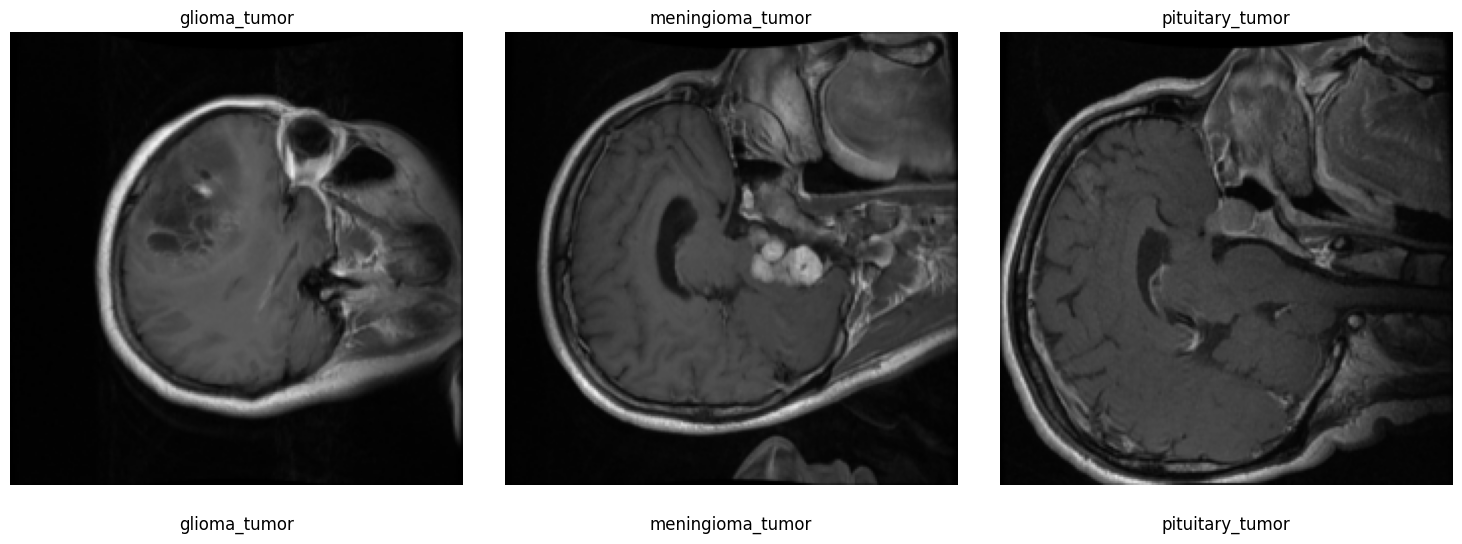

In [ ]:
def visualize_class_samples(dataset):
    classes = dataset.classes

    # Create a figure with subplots
    fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))

    # Loop through each class
    for i, cls in enumerate(classes):
        indices = np.where(np.array(dataset.targets) == i)[0]  # Indices of samples in this class
        selected_idx = np.random.choice(indices, size=1, replace=False)[0]  # Choose one image index

        image, _ = dataset[selected_idx]
        ax = axes[i]
        ax.imshow(np.transpose(image.numpy(), (1, 2, 0)))  # Transpose to (H, W, C)
        ax.set_title(cls)
        ax.axis('off')

        ax.text(0.5, -0.1, cls, transform=ax.transAxes, fontsize=12, ha='center')

    plt.tight_layout()
    plt.show()

visualize_class_samples(image_datasets['train'])

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
model = models.densenet121(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 86.4MB/s]


In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
num_classes = 3
model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)

In [ ]:
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(model.classifier.in_features, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),  # Adjust dropout rate as needed
    torch.nn.Linear(512, num_classes)
)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [ ]:
num_epochs = 20

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train
    train_losses.append(running_loss / len(dataloaders['train']))
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = correct_val / total_val
    val_losses.append(val_loss / len(dataloaders['val']))
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}]"
          f" Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.4f}"
          f" | Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.4f}")

    scheduler.step()

Epoch [1/20] Train Loss: 0.9728, Train Acc: 0.5508 | Val Loss: 0.9067, Val Acc: 0.4918
Epoch [2/20] Train Loss: 0.7599, Train Acc: 0.7197 | Val Loss: 0.6640, Val Acc: 0.8426
Epoch [3/20] Train Loss: 0.6339, Train Acc: 0.7831 | Val Loss: 0.5397, Val Acc: 0.8426
Epoch [4/20] Train Loss: 0.5410, Train Acc: 0.8209 | Val Loss: 0.4719, Val Acc: 0.8590
Epoch [5/20] Train Loss: 0.4727, Train Acc: 0.8428 | Val Loss: 0.4200, Val Acc: 0.8754
Epoch [6/20] Train Loss: 0.4411, Train Acc: 0.8465 | Val Loss: 0.3841, Val Acc: 0.8787
Epoch [7/20] Train Loss: 0.4104, Train Acc: 0.8573 | Val Loss: 0.3566, Val Acc: 0.8721
Epoch [8/20] Train Loss: 0.3890, Train Acc: 0.8568 | Val Loss: 0.3532, Val Acc: 0.8885
Epoch [9/20] Train Loss: 0.3890, Train Acc: 0.8559 | Val Loss: 0.3574, Val Acc: 0.8721
Epoch [10/20] Train Loss: 0.3861, Train Acc: 0.8605 | Val Loss: 0.3550, Val Acc: 0.8787
Epoch [11/20] Train Loss: 0.3918, Train Acc: 0.8545 | Val Loss: 0.3541, Val Acc: 0.8885
Epoch [12/20] Train Loss: 0.3760, Train A

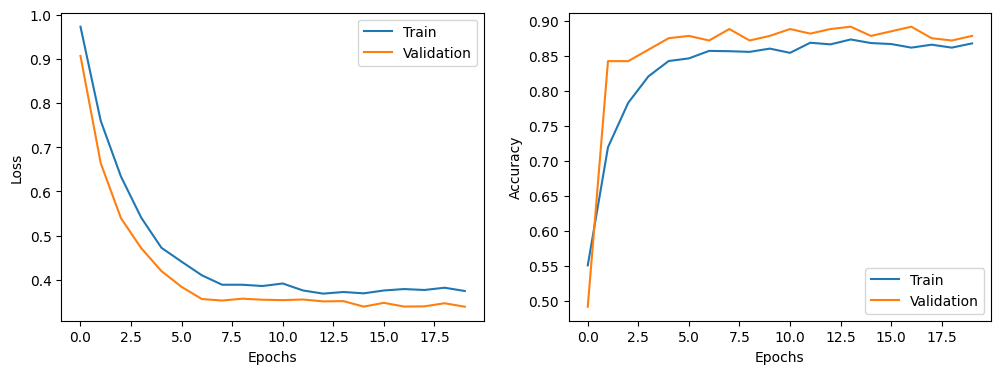

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
def evaluate_test_accuracy(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

# Call the function to get the test accuracy
test_accuracy = evaluate_test_accuracy(model, dataloaders['test'])
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.8602


In [ ]:
def predict_class(image_path):
    # Load an image
    image = Image.open(image_path).convert('RGB')


    # Preprocess the image
    input_tensor = transform(image)
    input_batch = input_tensor.unsqueeze(0).to(device)  # Move the input tensor to the appropriate device

    # Perform prediction
    with torch.no_grad():
        output = model(input_batch)

    # Get the predicted class
    _, predicted_class = torch.max(output, 1)

    return predicted_class.item()


In [ ]:
image_path = '/content/figshare-split/train/meningioma_tumor/152.png'  # Replace with the actual image path
predicted_class = predict_class(image_path)

class_names = ['Glioma Tumor', 'Meningioma Tumor', 'Pituitary Tumor']

print(f'Predicted Class: {class_names[predicted_class]}')

Predicted Class: Meningioma Tumor


In [ ]:
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {num_trainable_params}')

Number of trainable parameters: 7480195


In [ ]:
!pip install grad-cam

In [ ]:
for param in model.features.parameters():
    param.requires_grad = True

In [ ]:
def ReLU_inplace_to_False(module):
    for layer in module._modules.values():
        if isinstance(layer, nn.ReLU):
            layer.inplace = False
        ReLU_inplace_to_False(layer)
ReLU_inplace_to_False(model)

In [ ]:
print(model)

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

In [ ]:
image = Image.open(image_path).convert('RGB')
rgb_img = np.float32(image) / 255
input_tensor = preprocess(image)
input_tensor.unsqueeze_(0)  # Add batch dimension
input_tensor = input_tensor.to(device)

In [ ]:
target_layers = [model.features.denseblock4.denselayer16.conv2]

In [ ]:
cam = GradCAM(model=model, target_layers=target_layers)

In [ ]:
targets = [ClassifierOutputTarget(1)] #class label

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]

In [ ]:
print(input_tensor.shape)

torch.Size([1, 3, 224, 224])


In [ ]:
print(grayscale_cam.shape)

(224, 224)


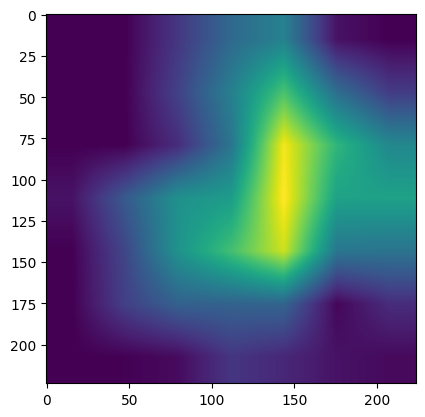

In [ ]:
plt.imshow(grayscale_cam)

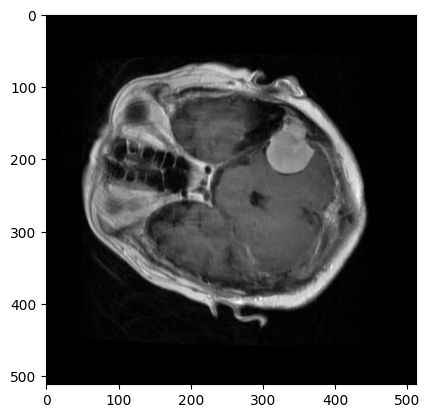

In [ ]:
plt.imshow(image)

In [ ]:
import cv2

In [ ]:
image_array = np.array(image)/255

In [ ]:
resized_heatmap = cv2.resize(grayscale_cam, (image_array.shape[1], image_array.shape[0]))

In [ ]:
visualization = show_cam_on_image(image_array, resized_heatmap, use_rgb=True)

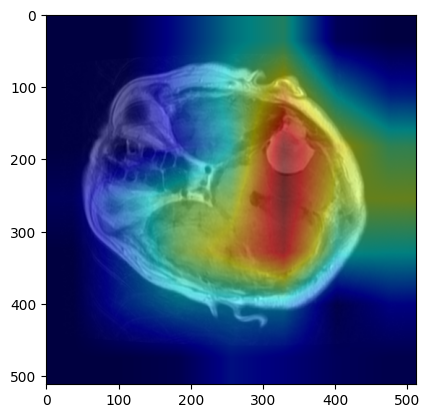

In [ ]:
plt.imshow(visualization)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report

model.eval()
all_preds_test = []
all_labels_test = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        all_preds_test.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

# Calculate test accuracy
test_accuracy = accuracy_score(all_labels_test, all_preds_test)
print(f"Test Accuracy: {test_accuracy}")

# Print classification report for test set
print("Classification Report:")
print(classification_report(all_labels_test, all_preds_test))

Test Accuracy: 0.8601626016260162
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       286
           1       0.74      0.69      0.72       143
           2       0.87      0.93      0.90       186

    accuracy                           0.86       615
   macro avg       0.84      0.84      0.84       615
weighted avg       0.86      0.86      0.86       615



In [ ]:
torch.save(model.state_dict(), 'model.pt')